In [1]:
import sys
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import datetime
from tqdm import tqdm
import GPy
from collections import defaultdict
from pathlib import Path
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import warnings
import time
from itertools import product
from joblib import Parallel, delayed
from operator import itemgetter
import sncosmo

mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True
# mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [2]:
path = os.path.dirname(os.getcwd())
os.chdir(path)
from Emulator.Classes.AllData import AllData
from Emulator.Classes.LightCurve import utkarshGrid, LightCurve
from Emulator.Classes.GP import GP
from Emulator.Classes.GP2D import GP2D
from Emulator.Classes.GP5D import GP5D
os.chdir(os.getcwd() + "/Emulator")
os.getcwd()

'/Users/utkarsh/PycharmProjects/KilonovaeLightCurves/Emulator'

In [3]:
curr_wv = np.arange(100, 3600, 10)
set_n_comp = 35
set_skip_factor = None

In [4]:
# gp = GP5D("Classes/reference.csv")
# gp.skip_factor = set_skip_factor
# gp.set_wv_range(curr_wv)
# gp.n_comp = set_n_comp
# gp.num_pca_components = (4,4)
# time_shape = None
# gp.setXY()
# # gp.save_pca_components(skip_factor = None)
# gp.save_trained_data()
# gp.ComputeDifferenceFlux()
# gp.plot_difference_histogram(binning = 150)
# plt.title("Error in only PCA Components (PCA Flux - Truth)/TRUTH")
# plt.xlabel("Units Log Flux (Error)")
# plt.ylabel("Count")
# plt.xlim(-1, 1)
# plt.show()

In [5]:
gp = GP5D("Classes/reference.csv")
gp.set_wv_range(curr_wv)
gp.n_comp = set_n_comp
time_shape = None
gp.num_pca_components = (10,10)
# gp.save_training_data(time_trauncation = time_shape) # Which wv do you want to extract.  
gp.save_pca_components(skip_factor = set_skip_factor)
gp.setXY()
fitting_kernel = GPy.kern.RBF(input_dim=4, variance = 10, lengthscale=10, ARD = True)
decay_kernel = GPy.kern.Linear(4 , ARD=True)
gp.kernel = fitting_kernel * decay_kernel
gp.model = GPy.models.GPRegression(gp.X,gp.Y,gp.kernel)
t0 = time.time()
print(f"[STATUS] Optimizing...")
gp.model.optimize_restarts(parallel = True, robust = True, num_restarts = 20)
print(f"[STATUS] {round(time.time() - t0, 2)}s taken to optimize.")
# gp.model.optimize(messages = True)
# display(gp.model.rbf.lengthscale)
display(gp.model.mul.rbf.lengthscale)
t1 = time.time()
gp.model_predict(include_like = False)
print(f"[STATUS] {round(time.time() - t1, 2)}s taken to predict.")
t2 = time.time()
gp.save_trained_data()
print(f"[STATUS] {round(time.time() - t2, 2)}s taken to save data.")
# gp.ComputeDifferenceFlux()
# gp.plot_difference_histogram(binning = 150)
# plt.xlim(-1,1)
# plt.show()

[STATUS] Setting X, Y components for 5D Model.
[STATUS] Optimizing...
Optimization restart 1/20, f = -6585.0556397063465
Optimization restart 2/20, f = -8857.383797699418
Optimization restart 3/20, f = -8857.383797543074
Optimization restart 4/20, f = -8857.383785541331
Optimization restart 5/20, f = -8857.383793670188
Optimization restart 6/20, f = -8857.383786614384
Optimization restart 7/20, f = -8731.794337892543
Optimization restart 8/20, f = -8857.383799864943
Optimization restart 9/20, f = -8857.38378552004
Optimization restart 10/20, f = -8731.794399446055
Optimization restart 11/20, f = -8857.383730950602
Optimization restart 12/20, f = -8857.383773294856
Optimization restart 13/20, f = -8857.383791431439
Optimization restart 14/20, f = -8857.38379919521
Optimization restart 15/20, f = -8857.383797413666
Optimization restart 16/20, f = -8857.383793599065
Optimization restart 17/20, f = -8857.38377818108
Optimization restart 18/20, f = -8857.383758536474
Optimization restart 19

index,GP_regression.mul.rbf.lengthscale,constraints,priors
[0],0.20773966,+ve,
[1],0.16828047,+ve,
[2],0.17659876,+ve,
[3],3.43257972,+ve,


[STATUS] Predicting X and Y with trained emulator.
[STATUS] 2.13s taken to predict.
[STATUS] 61.43s taken to save data.


=== Flux Estimation === 
mejdyn: 0.001
mejwind: 0.01        
phi: 45
viewing_angle: 4
wavelength: 250nm        
time: 2.0 days

LOG FLUX: -4.56866


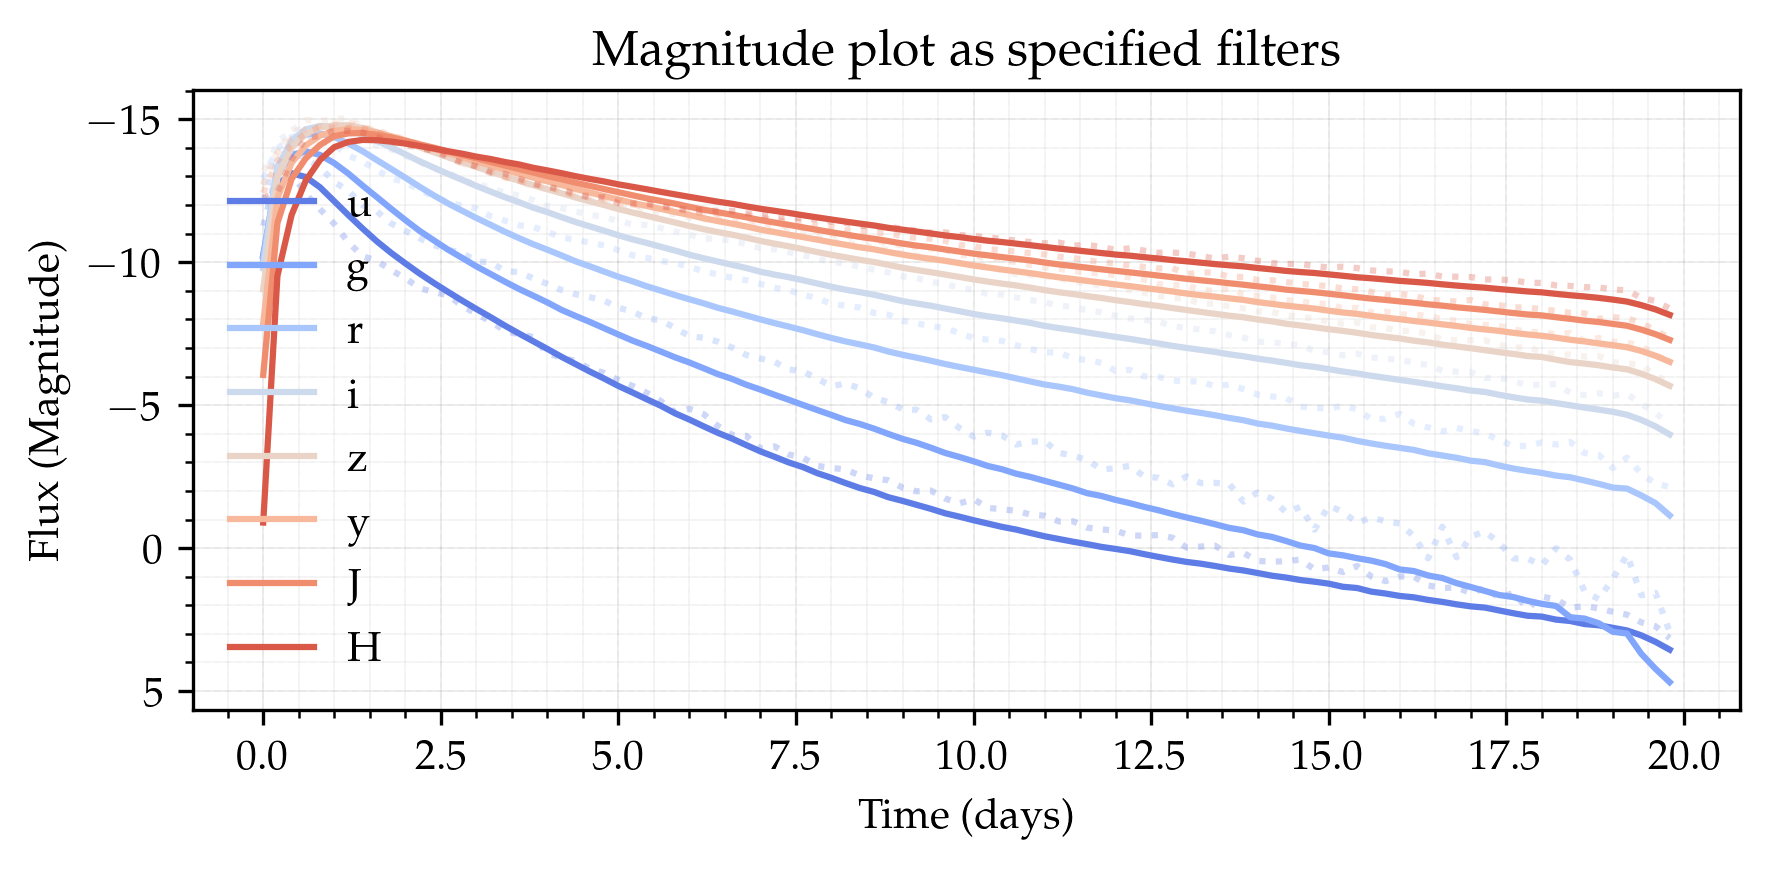

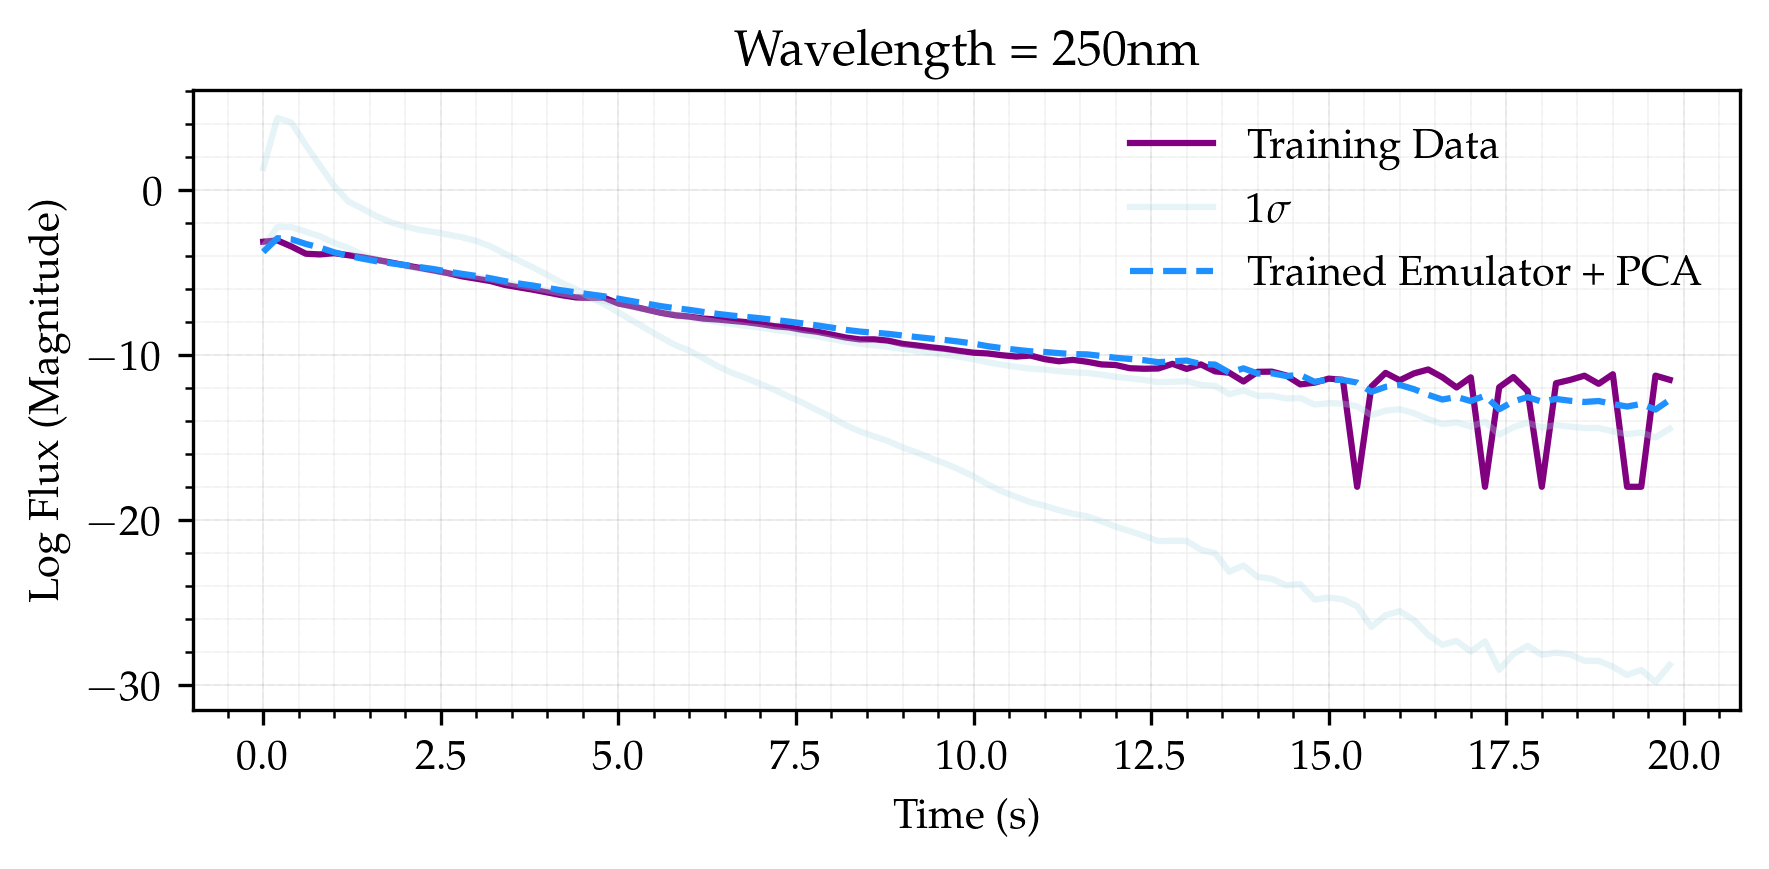

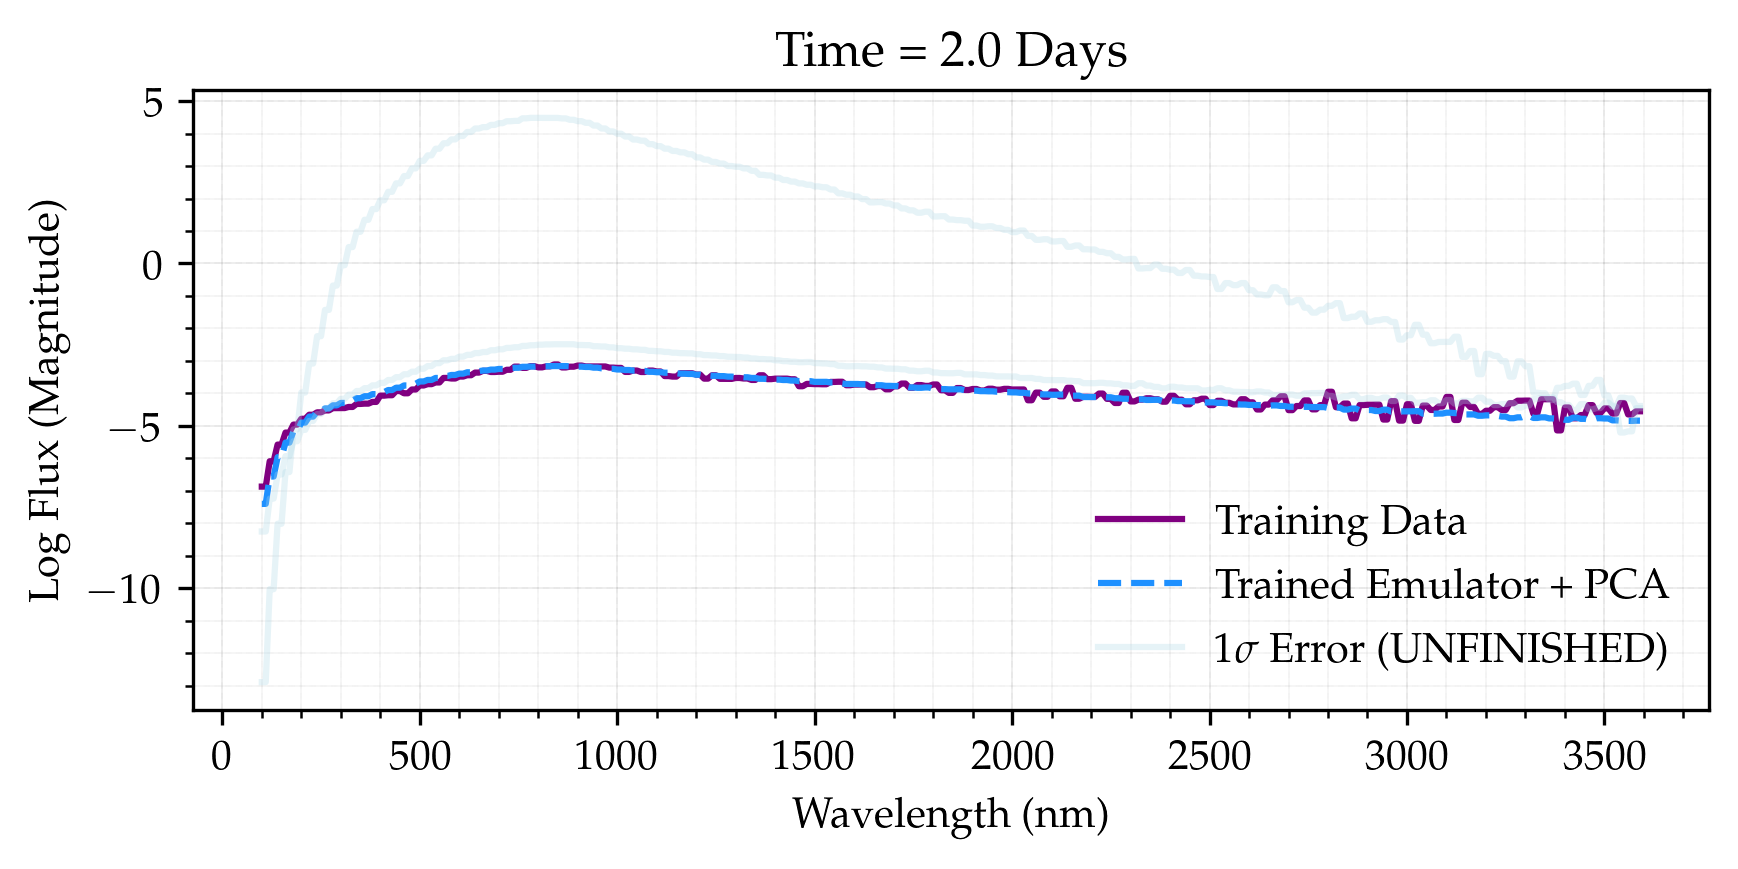

In [6]:
gp.plot_filters(mejdyn = 0.001, mejwind =  0.01, phi = 45, iobs = 4)
gp.get_flux(mejdyn = 0.001, mejwind =  0.01, phi = 45, iobs = 4, time_desired = 2, wv_desired = 250)
gp.overplot_time(mejdyn = 0.001, mejwind =  0.01, phi = 45, iobs = 4, wv_desired = 250)
gp.overplot_wavelength(mejdyn = 0.001, mejwind =  0.01, phi = 45, iobs = 4, time_desired = 2)
plt.show()

100%|██████████| 196/196 [00:02<00:00, 70.18it/s]


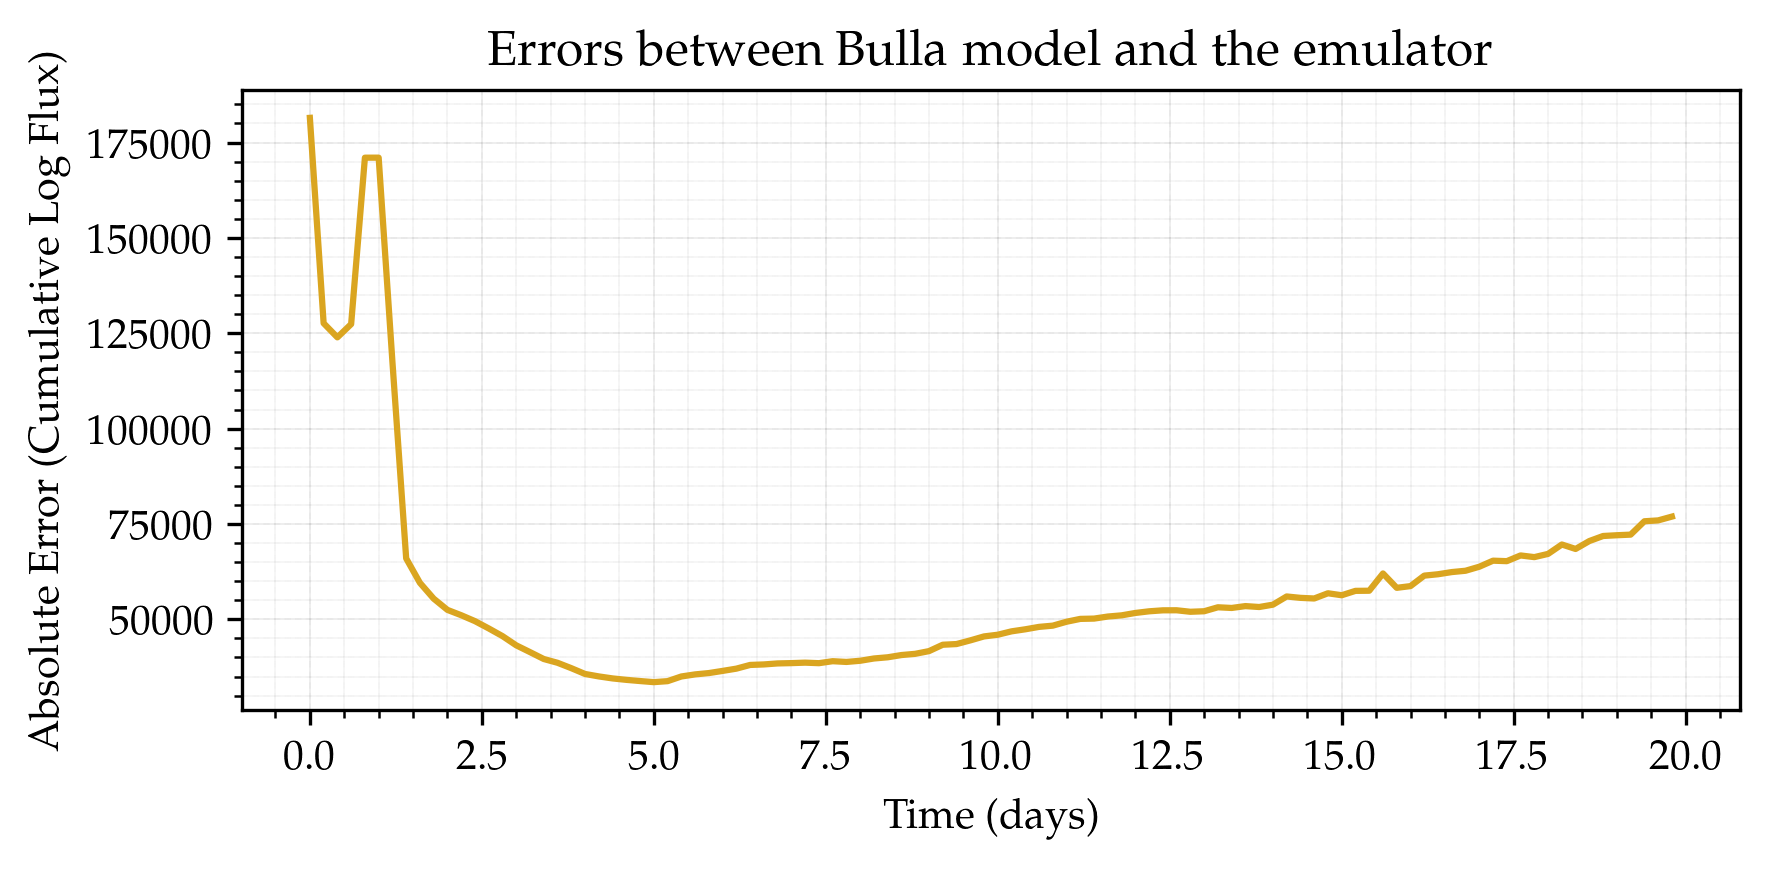

In [7]:
# Emulator Errors
# validation_element
self = gp
t = np.arange(gp.Ntime[0], gp.Ntime[1], gp.Ntime[1] / gp.Ntime[2])
diff = np.zeros(t.shape)
for index, row, in tqdm(self.reference.iterrows(), total = 196):
    for viewing_angle in self.iobs_range:
        mejdyn = row.mejdyn
        mejwind =  row.mejwind
        phi = row.phi
        iobs = viewing_angle

        untrained = np.load(f"data/pca/mejdyn{mejdyn}_mejwind{mejwind}_phi{phi}_iobs{iobs}.npy")
        trained = np.load(f"data/pcaTrained/mejdyn{mejdyn}_mejwind{mejwind}_phi{phi}_iobs{iobs}.npy")


        for i in range(len(t)):
            diff += abs(trained[:, i] - untrained[:, i])

plt.figure(dpi=300, figsize=(6, 3))
plt.plot(t, diff, color = "goldenrod")
utkarshGrid()
plt.title("Errors between Bulla model and the emulator")
# plt.ylabel("Absolute Error (Cumulative Magnitude)")
plt.ylabel("Absolute Error (Cumulative Log Flux)")
plt.xlabel("Time (days)")
plt.show()

## Single Cross Validation

In [8]:
# gp = GP5D("Classes/reference.csv")
# gp.set_wv_range(curr_wv)
# gp.n_comp = set_n_comp
# # gp.num_pca_components = (4,4)
# # gp.save_training_data(time_trauncation = None) # Which wv do you want to extract.  
# gp.save_pca_components(skip_factor = set_skip_factor)
# gp.setXY()
# fitting_kernel = GPy.kern.RBF(input_dim=4, variance = 10, lengthscale=10, ARD = True)
# decay_kernel = GPy.kern.Linear(4,ARD=True)
# gp.kernel = fitting_kernel * decay_kernel
# gp.LOOCV_PCA()
# gp.plot_loocv_histogram() # THIS IS FOR PCA COMPONENTS, NOT TRAINING DATA

In [9]:
# gp.save_trained_data()
# gp.ComputeDifferenceFlux()
# gp.plot_difference_histogram(binning = 100)
# plt.xlim(-1, 1)